In [15]:
import sys
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import cluster, datasets
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise

from random import randint

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

#hiding warning messages
import warnings
warnings.filterwarnings("ignore")

#Reading in Summary MERGED CSV
data = pd.read_csv('Train_Tox21')
data = data.astype(float, errors = 'ignore')
data = data.dropna()
data = data.reset_index(drop = True)
data.head()


,PUBCHEM_CID,Activity Outcome,MolecularFormula,MolecularWeight,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,CanonicalSMILES,IsomericSMILES,InChI,XLogP,ExactMass,TPSA,HeavyAtomCount,Complexity,target
0,4.0,inactive,C3H9NO,75.11,2.0,2.0,1.0,CC(CN)O,CC(CN)O,"InChI=1S/C3H9NO/c1-3(5)2-4/h3,5H,2,4H2,1H3",-1.0,75.068414,46.2,5.0,22.9,0.0
1,11.0,inactive,C2H4Cl2,98.96,0.0,0.0,1.0,C(CCl)Cl,C(CCl)Cl,InChI=1S/C2H4Cl2/c3-1-2-4/h1-2H2,1.5,97.969005,0.0,4.0,6.0,0.0
2,13.0,inactive,C6H3Cl3,181.40,0.0,0.0,0.0,C1=CC(=C(C=C1Cl)Cl)Cl,C1=CC(=C(C=C1Cl)Cl)Cl,InChI=1S/C6H3Cl3/c7-4-1-2-5(8)6(9)3-4/h1-3H,4.0,179.930033,0.0,9.0,94.3,0.0
3,33.0,inactive,C2H3ClO,78.50,0.0,1.0,1.0,C(C=O)Cl,C(C=O)Cl,"InChI=1S/C2H3ClO/c3-1-2-4/h2H,1H2",0.3,77.987242,17.1,4.0,20.0,0.0
4,34.0,inactive,C2H5ClO,80.51,1.0,1.0,1.0,C(CCl)O,C(CCl)O,"InChI=1S/C2H5ClO/c3-1-2-4/h4H,1-2H2",-0.1,80.002893,20.2,4.0,10.0,0.0


In [16]:
#Making a 'target column', where inactives are 0 and actives are 1
activity_list = data['Activity Outcome']
activity_list = activity_list.tolist()
target_list = []
i = 0

while (i < len(activity_list)):
    if (activity_list[i] == 'active antagonist'):
        target_list.append(1)
        i = i + 1
    elif (activity_list[i] == 'active agonist'):
        target_list.append(1)
        i = i + 1
    else:
        target_list.append(0)
        i = i + 1
        
#Making strings ints
target_list = [int(i) for i in target_list]

#adding target column to data
data['target'] = target_list
len(target_list)

5004

In [17]:
##ALSO drop pubchem_CID because thats not a feature
data_numerical = data.drop(['PUBCHEM_CID', 'ExactMass', 'CanonicalSMILES', 'IsomericSMILES', 'InChI', 'MolecularFormula'], axis = 1)

In [18]:
#Taking Dataframe of only Inactive values
###Drop all active agonists and active antagonists
df_inactive = data_numerical.drop(data_numerical.loc[data['Activity Outcome'] == 'active agonist'].index)
df_inactive = df_inactive.drop(df_inactive.loc[df_inactive['Activity Outcome'] == 'active antagonist'].index)
df_inactive = df_inactive.drop(['Activity Outcome'], axis = 1)

#Taking Dataframe of only Active values
##Dropping all inactive values
df_active = data_numerical.drop(data.loc[data['Activity Outcome'] == 'inactive'].index)
df_active = df_active.drop(['Activity Outcome'], axis = 1)

In [19]:
#Printing number of active compounds
print("Number of active compounds in data: ")
print(len(df_active.index))

Number of active compounds in data: 
361


# PCA

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.decomposition import PCA


In [21]:
#setting X equal to all numerical features, and standardizing data
features = ['MolecularWeight', 'XLogP', 'TPSA', 'HBondDonorCount', 'HBondAcceptorCount', 'RotatableBondCount', 'HeavyAtomCount', 'Complexity']
x = data_numerical.loc[:, features].values
y = data_numerical.loc[:,['target']].values
x = StandardScaler().fit_transform(x)

#projecting PCA to lower dimensions
pca = decomposition.PCA()
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'],)
#principalDf.head()
finalDf = pd.concat([principalDf, data_numerical['target']], axis = 1)
#finalDf['target'].value_counts()

In [22]:
#Explained Variance: how much information (variance) can be attributed to 
#each of the principal components
pca.explained_variance_ratio_

array([0.64161908, 0.21490586, 0.06457386, 0.03496871, 0.02369096,
       0.01139392, 0.00660606, 0.00224155])

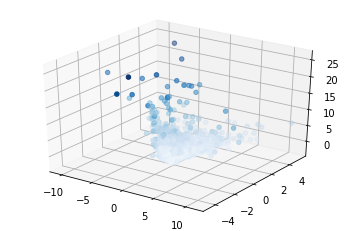

In [23]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')

zdata = finalDf['PC1']
xdata = finalDf['PC2']
ydata = finalDf['PC3']
ax.scatter3D(xdata, ydata, zdata, c = zdata, cmap = 'Blues')
ax.view_init(30, -55)

# Downsampling/Cluster Centroids

In [24]:
#splitting into inactive/active pca components
active_pca = finalDf.drop(finalDf.loc[finalDf['target'] == 0].index)
inactive_pca = finalDf.drop(finalDf.loc[finalDf['target'] == 1].index)

In [25]:
from sklearn.cluster import KMeans
import math

columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']
X = inactive_pca.loc[:, columns].values

clusters = 361
kmeans = KMeans(n_clusters = clusters)
kmeans.fit(X)

labels = kmeans.predict(X)

In [26]:
#Glue back to original data
inactive_pca['clusters'] = labels

#sorting by clusters
inactive_clusters = inactive_pca.sort_values(by = ['clusters'], ascending = True, inplace = False)
inactive_clusters = inactive_clusters.drop(columns = ['target'], axis = 1)

In [27]:
#list of cluster labels in order
cluster_list = inactive_clusters['clusters'].tolist()

#means of each cluster
cluster_means = inactive_clusters.groupby(['clusters']).mean()

In [28]:
#putting each pca component and each pca mean in a list
#6368 long (len of inactive compounds to undersample)
pc1 = inactive_clusters['PC1'].tolist()
pc2 = inactive_clusters['PC2'].tolist()
pc3 = inactive_clusters['PC3'].tolist()
pc4 = inactive_clusters['PC4'].tolist()
pc5 = inactive_clusters['PC5'].tolist()
pc6 = inactive_clusters['PC6'].tolist()
pc7 = inactive_clusters['PC7'].tolist()
pc8 = inactive_clusters['PC8'].tolist()

#605 long (bc 605 active compounds)
mean1 = cluster_means['PC1'].tolist()
mean2 = cluster_means['PC2'].tolist()
mean3 = cluster_means['PC3'].tolist()
mean4 = cluster_means['PC4'].tolist()
mean5 = cluster_means['PC5'].tolist()
mean6 = cluster_means['PC6'].tolist()
mean7 = cluster_means['PC7'].tolist()
mean8 = cluster_means['PC8'].tolist()

#generating lists
i = 0
cluster = 0
dist_list = []
#i_list = []
#index_min_list = []
downsampled_df = pd.DataFrame()

#loop for getting the distances from each cluster point to the mean
#taking the smallest distance
#appending that row to a dataframe (downsampled_df)
while (i < len(cluster_list)):
    dist = math.sqrt(math.pow((pc1[i] - mean1[cluster]), 2) + math.pow((pc2[i] - mean2[cluster]), 2) + 
                 math.pow((pc3[i] - mean3[cluster]), 2) + math.pow((pc4[i] - mean4[cluster]), 2) + 
                 math.pow((pc5[i] - mean5[cluster]), 2) + math.pow((pc6[i] - mean6[cluster]), 2) + 
                 math.pow((pc7[i] - mean7[cluster]), 2) + math.pow((pc8[i] - mean8[cluster]), 2))
    
    dist_list.append(dist)
    
    if (i == (len(pc1)-1)):
        min_dist = min(dist_list)
        list_index = dist_list.index(min_dist)
        df_index = (i - len(dist_list) + list_index + 1)
        row = pd.DataFrame(inactive_clusters.iloc[df_index]).T
        downsampled_df = downsampled_df.append(row)
        #print('end')
        break
    
    elif (cluster_list[i + 1]) == cluster_list[i]:
        i = i + 1
        #print('elif1')
        
    elif (cluster_list[i + 1]) > cluster_list[i]:
        min_dist = min(dist_list)
        list_index = dist_list.index(min_dist)
        df_index = (i - len(dist_list) + list_index + 1)
        row = pd.DataFrame(inactive_clusters.iloc[df_index]).T
        downsampled_df = downsampled_df.append(row)
        
        dist_list.clear()
        #print('elif2')
        #i_list.
        i = i + 1
        cluster = cluster + 1
        

In [29]:
downsampled_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,clusters
777,-0.013835,-1.058931,-0.214779,0.571711,0.175168,0.306113,0.036787,-0.007291,0.0
4667,0.163420,0.888304,-0.343728,0.438331,0.172806,-0.072777,-0.073298,0.103380,1.0
4528,11.960056,-1.404203,0.359920,-1.280048,0.303831,0.589822,0.222055,0.165603,2.0
3040,-0.471200,0.126840,0.767115,0.194761,-0.129734,0.257940,-0.028168,-0.142073,3.0
240,-1.052298,-0.981509,0.567083,0.051499,0.420428,-0.051969,-0.003860,-0.013360,4.0


In [30]:
#combining active pca data with other active molecular properties
active = pd.concat([active_pca, data], axis = 1).dropna()
#there are 2 for some reason?
active = active.drop(columns = ['target'], axis = 1)

#adding target column back
active['target'] = 1

#combining new downsampled inactive pca data with other inactive molecular properties
inactive = pd.concat([downsampled_df, data], axis = 1).dropna()

#dropping "clusters column" (it can be found in downsampled_df)
inactive = inactive.drop(columns = ['clusters'], axis = 1)

#adding target column back
inactive['target'] = 0

#combining active and inactive dataframes!!!!
act_inact_final = pd.concat([active, inactive])
act_inact_final

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PUBCHEM_CID,Activity Outcome,...,RotatableBondCount,CanonicalSMILES,IsomericSMILES,InChI,XLogP,ExactMass,TPSA,HeavyAtomCount,Complexity,target
140,-1.403337,-0.503341,-0.387764,-0.082259,-0.278501,-0.000986,-0.089140,0.055148,1923.0,active agonist,...,0.0,C1=CC2=C(C(=C1)O)N=CC=C2,C1=CC2=C(C(=C1)O)N=CC=C2,InChI=1S/C9H7NO/c11-8-5-1-3-7-4-2-6-10-9(7)8/h...,2.0,145.052764,33.1,11.0,138.0,1
161,-0.114826,0.268539,-1.038696,0.154652,0.502283,-0.237560,0.066917,0.154261,2118.0,active antagonist,...,1.0,CC1=NN=C2N1C3=C(C=C(C=C3)Cl)C(=NC2)C4=CC=CC=C4,CC1=NN=C2N1C3=C(C=C(C=C3)Cl)C(=NC2)C4=CC=CC=C4,InChI=1S/C17H13ClN4/c1-11-20-21-16-10-19-17(12...,2.1,308.082874,43.1,22.0,434.0,1
178,2.891772,1.015351,-0.548019,1.033463,0.017861,0.398095,-0.157217,-0.126047,2176.0,active agonist,...,8.0,CCOC(=O)OC(C)OC1=C(N(S(=O)(=O)C2=CC=CC=C21)C)C...,CCOC(=O)OC(C)OC1=C(N(S(=O)(=O)C2=CC=CC=C21)C)C...,InChI=1S/C20H21N3O7S/c1-4-28-20(25)30-13(2)29-...,4.0,447.110021,133.0,31.0,808.0,1
180,-0.357005,-0.033105,-0.441273,0.566864,-0.057438,0.691294,0.277729,0.042834,2194.0,active antagonist,...,2.0,COC1=CC=C(C=C1)C2=CC(=S)SS2,COC1=CC=C(C=C1)C2=CC(=S)SS2,InChI=1S/C10H8OS3/c1-11-8-4-2-7(3-5-8)9-6-10(1...,2.8,239.973728,91.9,14.0,254.0,1
185,2.381299,0.265859,-0.401451,0.916811,0.416766,0.295284,-0.221053,-0.110032,2225.0,active antagonist,...,7.0,CC1=C(C(C(=C(N1)C)C(=O)OCC(=O)C)C2=CC=CC=C2[N+...,CC1=C(C(C(=C(N1)C)C(=O)OCC(=O)C)C2=CC=CC=C2[N+...,InChI=1S/C19H20N2O7/c1-10(22)9-28-19(24)16-12(...,2.0,388.127051,128.0,28.0,748.0,1
201,3.760898,-0.482172,0.372794,0.807793,0.150859,0.287426,0.140671,0.051511,2320.0,active agonist,...,10.0,CC1=NC=C(C(=N1)N)CN(C=O)C(=C(CCOP(=O)(O)O)SC(=...,CC1=NC=C(C(=N1)N)CN(C=O)C(=C(CCOP(=O)(O)O)SC(=...,InChI=1S/C19H23N4O6PS/c1-13(23(12-24)11-16-10-...,0.5,466.107593,181.0,31.0,697.0,1
205,-1.173631,1.503762,-1.291897,-0.583126,-0.268941,-0.065714,-0.193898,0.094492,2336.0,active agonist,...,0.0,C1=CC=C2C3=C4C(=CC2=C1)C=CC5=C4C(=CC=C5)C=C3,C1=CC=C2C3=C4C(=CC2=C1)C=CC5=C4C(=CC=C5)C=C3,InChI=1S/C20H12/c1-2-7-17-15(4-1)12-16-9-8-13-...,6.0,252.093900,0.0,20.0,372.0,1
217,-0.630351,0.419497,-0.342587,-0.533340,-0.901237,0.073446,-0.061745,0.081660,2374.0,active antagonist,...,2.0,CC(C)(C)C1=CC(=C(C=C1O)C(C)(C)C)O,CC(C)(C)C1=CC(=C(C=C1O)C(C)(C)C)O,"InChI=1S/C14H22O2/c1-13(2,3)9-7-12(16)10(8-11(...",4.6,222.161980,40.5,16.0,208.0,1
228,0.426478,0.429387,-1.211972,0.307866,0.328074,0.043305,0.488269,0.034091,2451.0,active antagonist,...,1.0,CC1=NN=C2N1C3=C(C=C(S3)Br)C(=NC2)C4=CC=CC=C4Cl,CC1=NN=C2N1C3=C(C=C(S3)Br)C(=NC2)C4=CC=CC=C4Cl,InChI=1S/C15H10BrClN4S/c1-8-19-20-13-7-18-14(9...,2.8,391.949810,71.3,22.0,465.0,1
229,-0.874538,0.120737,-0.747511,-0.248237,-0.375617,-0.150804,0.541453,-0.117770,2453.0,active antagonist,...,0.0,C1=CC2=C(C(=C(C=C2Br)Br)O)N=C1,C1=CC2=C(C(=C(C=C2Br)Br)O)N=C1,InChI=1S/C9H5Br2NO/c10-6-4-7(11)9(13)8-5(6)2-1...,3.2,302.871740,33.1,13.0,191.0,1


In [31]:
#Writing to csv
act_inact_final.to_csv('Downsampled_Tox21_Full', index = False)


# MISC CODE

In [ ]:
#Undersampling: Cluster Centroids

In [ ]:
#standardizing
#df_std = stats.zscore(pca_data)

#Cluster the data
km = KMeans(n_clusters=605, random_state=0)
km.fit_predict(df_inactive)
km.predict(df_active)
cls_id = km.labels_
ctr_crd = km.cluster_centers_
n_clusters_ = len(ctr_crd)

In [ ]:
metrics.silhouette_score(df_inactive, cls_id, metric='euclidean')

In [ ]:
df_inactive_arr = np.array(df_inactive)
df_active_arr = np.array(df_active)

In [ ]:
len(X_dist_inact)

In [ ]:
members = []
num_actives = []
num_inactives = []
dist_to_center = []
X_dist_act = []
X_dist_inact = []

for i in range( len( ctr_crd ) ) :    #-- Initialize the arrays.

    members.append( [] )
    num_actives.append( 0 )
    num_inactives.append( 0 )
    dist_to_center.append( [] )

for i in range( len( df_inactive ) ) :

    members[ cls_id[i] ].append( i )

    dist_to_center_tmp = pairwise.euclidean_distances( df_inactive_arr[i].reshape(1,-1), ctr_crd[ cls_id[i] ].reshape(1, -1))
    dist_to_center[cls_id[i]].append( dist_to_center_tmp )

    X_dist_inact.append( dist_to_center_tmp[0][0] )
    
for i in range( len( df_active ) ) :

    dist_to_center_tmp = pairwise.euclidean_distances( df_active_arr[i].reshape(1,-1), ctr_crd[ cls_id[i] ].reshape(1, -1))

    X_dist_act.append( dist_to_center_tmp[0][0] )

#for i in range( len( ctr_crd ) ) :

#    for j in range( len( ctr_crd[ i ] ) ) :
#        print( "\t%14.6e" % ctr_crd[i][j], end='')

pd.DataFrame(ctr_crd)

In [ ]:
#standardizing
clmns = ['MolecularWeight','XLogP','TPSA','HBondDonorCount','HBondAcceptorCount','RotatableBondCount','HeavyAtomCount','Complexity']
df_std = stats.zscore(df_transformed)

#Cluster the data
kmeans = KMeans(n_clusters=605, random_state=0).fit(df_std)
labels = kmeans.labels_


#Glue back to originaal data
df_numerical['clusters'] = labels

#Add the column into our list
clmns.extend(['clusters'])

#Lets analyze the clusters
#print(df_numerical[clmns].groupby(['clusters']).mean())

df_numerical = df_numerical.sort_values(by = ['clusters'], ascending = True, inplace = False)
df_numerical.head(20)

In [ ]:
metrics.silhouette_score(df_numerical, cls_id, metric='euclidean')

In [ ]:
sns.lmplot('XLogP', 'TPSA', 
           data=df_numerical, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 10})
plt.title('Clusters XLogP vs TPSA')
plt.xlabel('XLogP')
plt.ylabel('TPSA')

In [ ]:
print(df_numerical[clmns].groupby(['clusters']).mean())

In [ ]:
#also PCA and Undersampling

In [ ]:
#df_numerical_no_targets = df_numerical.drop(columns = ['target'], axis = 1)
clmns2 = ['ExactMass', 'TPSA', 'XLogP']
X = np.array(data[clmns2])
y = np.array(data['target'])

In [ ]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

    
    
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')
    
    
    
    

cc = ClusterCentroids(ratio={0: 605})
X_cc, y_cc = cc.fit_sample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluser Centroids under-sampling')

In [ ]:
len(y_cc)

In [ ]:
from math import sqrt
def CCMUT(X,f):
    # 1. finding cluster centroid....
    cluster_centroid = np.sum(X,axis=0)/X.shape[0]
    # 2. finding Euclidean Distance from cluster centroid to samples
    euclidean = [None]*X.shape[0]
    for i in range(0,X.shape[0]):
        euclidean[i] = sqrt(sum((cluster_centroid-X[i])**2))
    # 3. tracking indices of samples in descending order of distance
    indices = list(reversed(sorted(range(len(euclidean)), 
    key = lambda j: euclidean[j])))
    # 4. removing the instances or under-sampling order-wise....
    X_f = np.delete(X, indices[:int(f/100*X.shape[0])], axis=0)
    # 5. returning the under-sampled Majority Sample Matrix
    return X_f

CCMUT(df_numerical, .5)